# Clasificación de imágenes con KMeans y Transfer Learning

En esta práctica se comprenderan los métodos de transferencia de conocimiento para extracción de características para la clasificación de imágenes sin etiquetar haciendo uso de técnicas de Aprendizaje Máquina No Supervisado. Como datos se utilizaran imágenes de CT de cabeza, cadera, pelvis y hombros, así como imágenes de ultrasonido de tumores de mama y cerebro fetal.

1. Cargar modelos de redes convolucionales con TensorFlow y Keras
2. Abrir Imágenes
3. Extraer características mediante transferencia de conocimiento
4. Analizar imágenes de acuerdo a sus caracteristicas extraidas
5. Entrenar y validar método de clusterización KMeans utilizando SKLEARN

## 1. Cargar modelos de redes convolucionales con TensorFlow y Keras

__TensorFlow:__ es una biblioteca de código abierto para aprendizae automático a traces de un rango de tareas, desarrollo por Google.

__Keras:__ es una biblioteca de Redes Neuronales Profundas de código abierto escrita en Python, capaz de de usar __TensorFlow__, MS Cognitive Toolkit o Theano como frameworks de procesamiento. 

__Keras Model:__ objeto que recibe tensores de entrada y tiene tensores de salida, el cual incluye capas de procesamiento que transorman una entrada a en una salida b.

Keras tiene modelos pre-entrenados con diferentes bases de datos los cuales se pueden descargar 

- Xception
- VGG16
- VGG19
- ResNet, ResNetV2
- InceptionV3
- InceptionResNetV2
- MobileNet
- MobileNetV2
- DenseNet
- NASNet

### VGG16

Es un modelo con sus pesos pre-entrenados con ImageNet
Tiene un tamaño de imagen de entrada default de 224x224 en 3 canales

Se puede descargar como una red totalmente convolucional (Segmentación) o como una red de clasificación con capas totalmente conectadas (clasificación)

keras.applications.vgg16.VGG16(..)

__include_top:__
bool
Si incluye capas totalmente conectadas
_default = True,_ 

__weights:__
'file', DataSet
Archivo o base de datos para cargar pesos pre-entrenados
_default ='imagenet'_

__pooling:__
None, 'avg', 'max'
Modo para extracción de características, cambia el modo de salida de la red
None: salida tal cual de la ultima capa convolucional, tensor 4D
avg: se aplica averge_pooling a la ultima capa convolucional resultando en un tensor 2D
max: se aplica max_pooling
_default = None_

In [1]:
!conda install tensorflow

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
from keras.applications.vgg16 import VGG16

#Download or load pretrained model 
model = VGG16(weights='imagenet', include_top=False)
model.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## 2. Abrir Imágenes

In [3]:
import os
import pydicom
from matplotlib import pyplot as plt
import cv2
import numpy as np

def readImage(img_filename,img_path):
    
    image = cv2.imread(img_path + img_filename, 0)
    image = cv2.resize(image, (224, 224))
    
    #Normalizing image
    high = 255
    low = 0
    cmin = image.min()
    cmax = image.max()
    cscale = cmax - cmin
    scale = float(high - low) / cscale
    new_array = (image - cmin) * scale + low
    image = (new_array.clip(low, high) + 0.5).astype(np.uint8)
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    img_data = image.reshape(1, 224, 224, 3)
    
    return img_data

def readDICOMImage(img_filename,img_path):
    
    dicom_img = pydicom.dcmread(img_path + img_filename)
    
    #Normalizing image
    high = 255
    low = 0
    cmin = dicom_img.pixel_array.min()
    cmax = dicom_img.pixel_array.max()
    cscale = cmax - cmin
    scale = float(high - low) / cscale
    new_array = (dicom_img.pixel_array - cmin) * scale + low
    image = (new_array.clip(low, high) + 0.5).astype(np.uint8)
    
    # resize image
    dim = (224, 224)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    img_data = image.reshape(1, 224, 224, 3)
    
    return img_data

In [4]:
#CT images paths
head_ct_path = "Data/CT_images/Head/"
hip_ct_path = "Data/CT_images/Hip/"
pelvis_ct_path = "Data/CT_images/Pelvis/"
shoulder_ct_path = "Data/CT_images/Shoulder/"

#US images paths
breast_us_path = "Data/US_images/Breast/"
brain_us_path = "Data/US_images/Brain/"

#CT images filenames
head_ct_files = next(os.walk(head_ct_path))[2]
hip_ct_files = next(os.walk(hip_ct_path))[2]
pelvis_ct_files = next(os.walk(pelvis_ct_path))[2]
shoulder_ct_files = next(os.walk(shoulder_ct_path))[2]

#US images filenames
breast_us_files = next(os.walk(breast_us_path))[2]
brain_us_files = next(os.walk(brain_us_path))[2]

#CT Images
head_images = []
hip_images = []
pelvis_images = []
shoulder_images = []

#US Images
breast_images = []
brain_images = []

#Read all CT Images

for filename in head_ct_files:
    head_images.append(readDICOMImage(filename,head_ct_path))
print("Number of head images: " + str(len(head_images)))

for filename in hip_ct_files:
    hip_images.append(readDICOMImage(filename,hip_ct_path))
print("Number of hip images: " + str(len(hip_images)))

for filename in pelvis_ct_files:
    pelvis_images.append(readDICOMImage(filename,pelvis_ct_path))
print("Number of pelvis images: " + str(len(pelvis_images)))

for filename in shoulder_ct_files:
    shoulder_images.append(readDICOMImage(filename,shoulder_ct_path))
print("Number of shoulder images: " + str(len(shoulder_images)))

#Read all US Images

for filename in breast_us_files:
    breast_images.append(readImage(filename,breast_us_path))
print("Number of breast images: " + str(len(breast_images)))

for filename in brain_us_files:
    brain_images.append(readImage(filename,brain_us_path))
print("Number of brain images: " + str(len(brain_images)))


Number of head images: 308
Number of hip images: 714
Number of pelvis images: 206
Number of shoulder images: 910
Number of breast images: 1001
Number of brain images: 285


In [5]:
## Downsample data if balance of classes required
def downSampleData(images,n_data):

    shuffled_indices = np.arange(len(images))
    np.random.shuffle(shuffled_indices)
    idx = shuffled_indices[:n_data]
    less_images = np.array(images)[idx]
    
    return less_images
    
head_images = downSampleData(head_images,206)
print("Number of head images: " + str(len(head_images)))
hip_images = downSampleData(hip_images,206)
print("Number of hip images: " + str(len(hip_images)))
pelvis_images = downSampleData(pelvis_images,206)
print("Number of pelvis images: " + str(len(pelvis_images)))
shoulder_images = downSampleData(shoulder_images,206)
print("Number of shoulder images: " + str(len(shoulder_images)))
breast_images = downSampleData(breast_images,206)
print("Number of breast images: " + str(len(breast_images)))
brain_images = downSampleData(brain_images,206)
print("Number of brain images: " + str(len(brain_images)))

Number of head images: 206
Number of hip images: 206
Number of pelvis images: 206
Number of shoulder images: 206
Number of breast images: 206
Number of brain images: 206


## 3. Extraer características con transferencia de conocimientos

Transfer learning nos ayuda para procesar una imgen y extraer un conjunto de valores que describan al problema. 
Haciendo uso de las Redes Convolucionales se puede hacer la extracción de características para cada imagen, mediante modelos pre-entrenados con un conjunto de imágenes diferente, sin  la necesidad de entrenar los modelos, ya que no se cuentan con datos anotados por expertos.

### VGG16

Extraer un arreglo de (1, 7, 7, 512) = 25088 características


In [6]:
#extract features froma an image
vgg16_feature = model.predict(head_images[0])
print(vgg16_feature.shape)

(1, 7, 7, 512)


25088


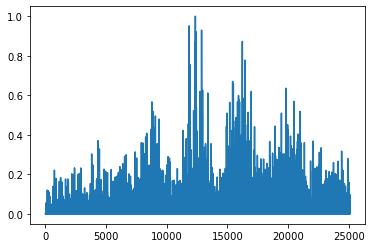

In [7]:
#Extract features for all images
def extractFeatures(image):

    vgg16_feature = model.predict(image)
    vgg16_feature_np = np.array(vgg16_feature)
    
    features = vgg16_feature_np.flatten()
    features = cv2.normalize(features,features,0,1,cv2.NORM_MINMAX)
    
    return features

head_features = []
hip_features = []
pelvis_features = []
shoulder_features = []
breast_features = []
brain_features = []

for i in range(206):
    
    head_features.append(extractFeatures(head_images[i]))
    hip_features.append(extractFeatures(hip_images[i]))
    pelvis_features.append(extractFeatures(pelvis_images[i]))
    shoulder_features.append(extractFeatures(shoulder_images[i]))
    breast_features.append(extractFeatures(breast_images[i]))
    brain_features.append(extractFeatures(brain_images[i]))
    
print(len(head_features[0]))
plt.plot(head_features[0])


## 4. Analizar imágenes de acuerdo a sus caracteristicas extraidas

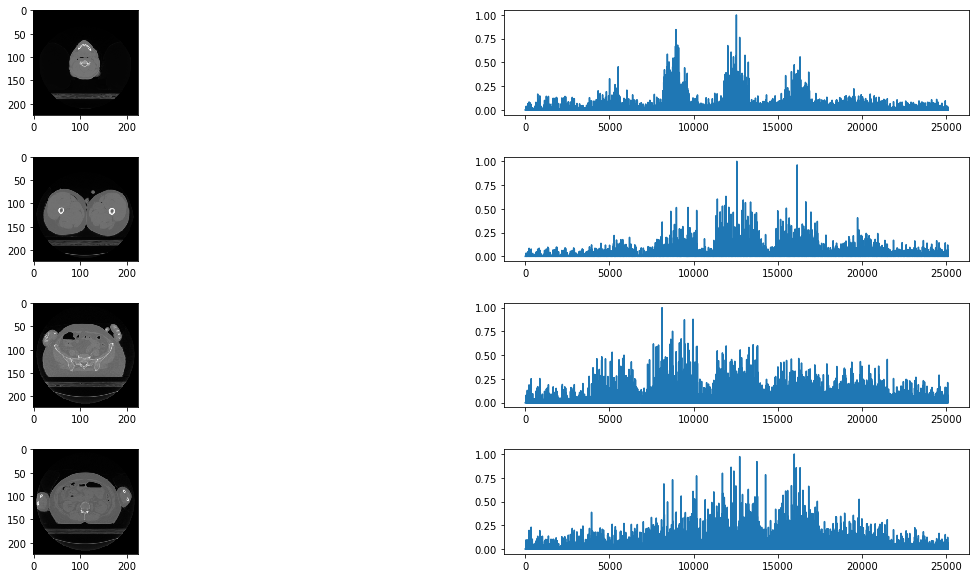

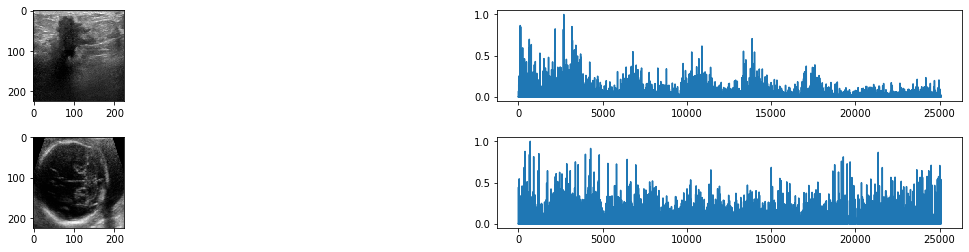

In [8]:
#Get random image from each type
import random

n = random.randint(0,len(head_images))
im_head = head_images[n]
feature_head = head_features[n]

n = random.randint(0,len(hip_images))
im_hip = hip_images[n]
feature_hip = hip_features[n]

n = random.randint(0,len(pelvis_images))
im_pelvis = pelvis_images[n]
feature_pelvis = pelvis_features[n]

n = random.randint(0,len(shoulder_images))
im_shoulder = shoulder_images[n]
feature_shoulder = shoulder_features[n]

n = random.randint(0,len(breast_images))
im_breast = breast_images[n]
feature_breast = breast_features[n]

n = random.randint(0,len(brain_images))
im_brain = brain_images[n]
feature_brain = brain_features[n]

#Displaying CT images and histograms
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(4, 2, 1)
ax.imshow(im_head[0,:,:,0], cmap="gray")

ax = fig.add_subplot(4, 2, 2)
ax.plot(feature_head) 

ax = fig.add_subplot(4, 2, 3)
ax.imshow(im_hip[0,:,:,0], cmap="gray")

ax = fig.add_subplot(4, 2, 4)
ax.plot(feature_hip) 

ax = fig.add_subplot(4, 2, 5)
ax.imshow(im_pelvis[0,:,:,0], cmap="gray")

ax = fig.add_subplot(4, 2, 6)
ax.plot(feature_pelvis) 

ax = fig.add_subplot(4, 2, 7)
ax.imshow(im_shoulder[0,:,:,0], cmap="gray")

ax = fig.add_subplot(4, 2, 8)
ax.plot(feature_shoulder) 


#Displaying US images and histograms
fig = plt.figure(figsize=(20,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_breast[0,:,:,0], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.plot(feature_breast) 

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_brain[0,:,:,0], cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.plot(feature_brain) 


## Entrenar y validar método de clusterización KMeans utilizando SKLEARN:

In [9]:
#Create training  and class validation data

#Concatenating all arrays
train_features = np.concatenate((head_features,hip_features,pelvis_features,
                                   shoulder_features,breast_features,brain_features),axis=0)

head_train_class = np.full(len(head_features),0)
hip_train_class = np.full(len(hip_features),1)
pelvis_train_class = np.full(len(pelvis_features),2)
shoulder_train_class = np.full(len(shoulder_features),3)
breast_train_class = np.full(len(breast_features),4)
brain_train_class = np.full(len(brain_features),5)

train_class = np.concatenate((head_train_class,hip_train_class,pelvis_train_class,
                                   shoulder_train_class,breast_train_class,brain_train_class),axis=0)

#Shuffle data to avoid local minima
shuffled_indices = np.arange(len(train_features))
np.random.shuffle(shuffled_indices)
train_features = train_features[shuffled_indices]
train_class = train_class[shuffled_indices]

print(train_class)
print("Training data shape: " + str(train_features.shape))

[4 1 4 ... 4 3 1]
Training data shape: (1236, 25088)


In [10]:
from sklearn.cluster import KMeans 

#Train KMeans with data
Kmeans = KMeans(n_clusters=6)
Kmeans.fit(train_features)

#np.set_printoptions(threshold=3)

#Print Kmeans TRaining results
print(Kmeans.cluster_centers_)
print(Kmeans.labels_)
print(Kmeans.inertia_)
print(Kmeans.n_iter_)

[[ 5.8207661e-10  3.4924597e-09  7.5669959e-10 ...  1.1579040e-02
   3.4880593e-02  0.0000000e+00]
 [ 5.8207661e-10  3.9581209e-09  8.7311491e-10 ...  5.0541695e-02
   8.4263563e-02  0.0000000e+00]
 [ 4.8584121e-04  9.8951217e-03  2.9479773e-03 ...  4.3570623e-04
   2.1904774e-02  0.0000000e+00]
 [ 5.8207661e-10  3.9581209e-09  8.7311491e-10 ...  7.4444309e-02
   9.9995986e-02  0.0000000e+00]
 [ 1.5501401e-03  1.8750059e-03  1.6805230e-04 ... -4.0978193e-08
   3.1993121e-02  0.0000000e+00]
 [ 5.5297278e-10  2.3283064e-09  5.2386895e-10 ...  2.8125530e-02
   5.9504960e-02  0.0000000e+00]]
[2 5 2 ... 2 3 3]
41943.169500772805
23


In [11]:
#Get  of each label
class_0_idx = np.where(Kmeans.labels_==0)[0]
class_1_idx = np.where(Kmeans.labels_==1)[0]
class_2_idx = np.where(Kmeans.labels_==2)[0]
class_3_idx = np.where(Kmeans.labels_==3)[0]
class_4_idx = np.where(Kmeans.labels_==4)[0]
class_5_idx = np.where(Kmeans.labels_==5)[0]

In [12]:
#Get cluster statistics
def getTypesInCluster(class_gt):
    
    n_classes = 6
    
    n_total = len(class_gt)
    n_elements_class = []
    
    for i in range(n_classes):
        class_idx = np.where(class_gt==i)[0]
        n_elements_class.append(len(class_idx))
    
    return n_total,n_elements_class

#Get ground truth class for each cluster point
class_0_gt = train_class[class_0_idx]
class_1_gt = train_class[class_1_idx]
class_2_gt = train_class[class_2_idx]
class_3_gt = train_class[class_3_idx]
class_4_gt = train_class[class_4_idx]
class_5_gt = train_class[class_5_idx]

#Get cluster statistics
n_total_0,n_elements_0 = getTypesInCluster(class_0_gt)
n_total_1,n_elements_1 = getTypesInCluster(class_1_gt)
n_total_2,n_elements_2 = getTypesInCluster(class_2_gt)
n_total_3,n_elements_3 = getTypesInCluster(class_3_gt)
n_total_4,n_elements_4 = getTypesInCluster(class_4_gt)
n_total_5,n_elements_5 = getTypesInCluster(class_5_gt)

print(n_total_0)
print(n_elements_0)
print(n_total_1)
print(n_elements_1)
print(n_total_2)
print(n_elements_2)
print(n_total_3)
print(n_elements_3)
print(n_total_4)
print(n_elements_4)
print(n_total_5)
print(n_elements_5)

205
[205, 0, 0, 0, 0, 0]
217
[0, 7, 206, 4, 0, 0]
206
[0, 0, 0, 0, 206, 0]
220
[1, 17, 0, 202, 0, 0]
206
[0, 0, 0, 0, 0, 206]
182
[0, 182, 0, 0, 0, 0]


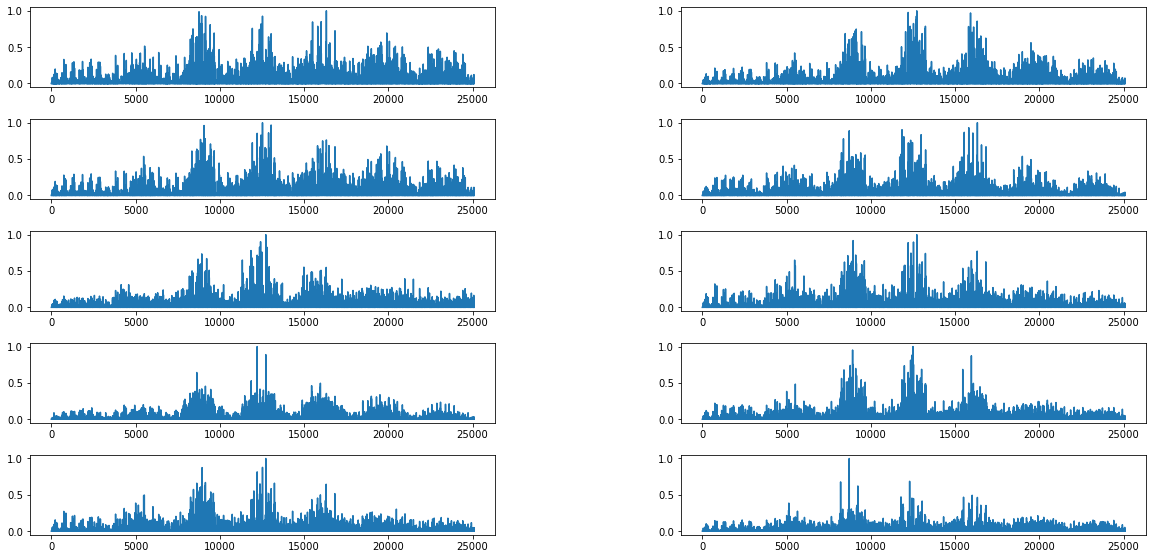

In [13]:
#Get cluster statistics
def printFeaturesCluster(features, n_images = 10):
        
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

    
        for j in range(n_images):
            
            n = random.randint(0,len(features)-1)
            
            
            ax = fig.add_subplot(n_images, 2, j+1)
            ax.plot(features[n-1])

            
class_0_features = train_features[class_0_idx]
printFeaturesCluster(class_0_features)

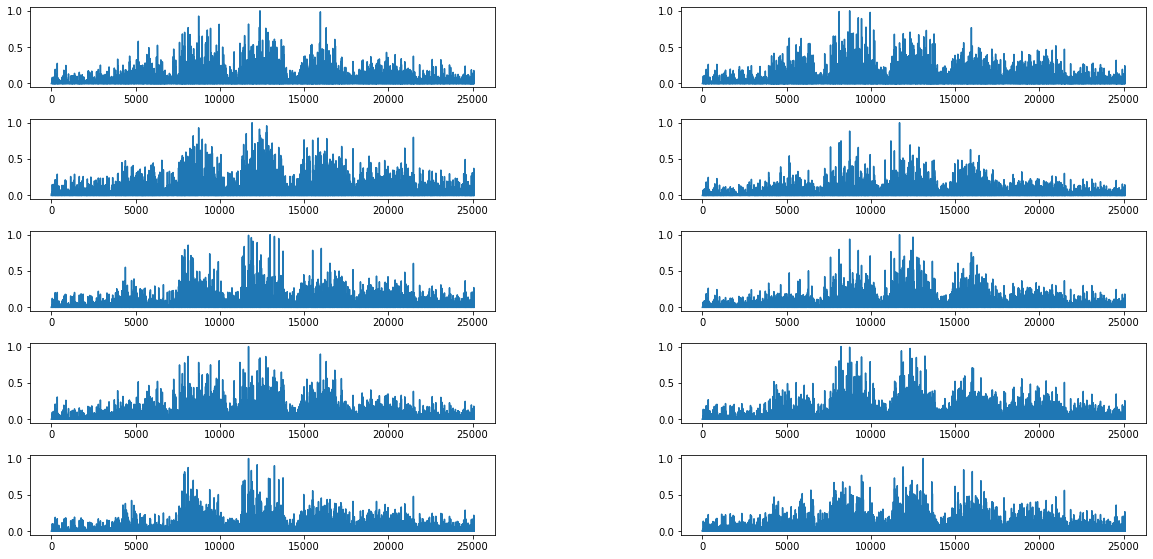

In [14]:
class_1_features = train_features[class_1_idx]
printFeaturesCluster(class_1_features)

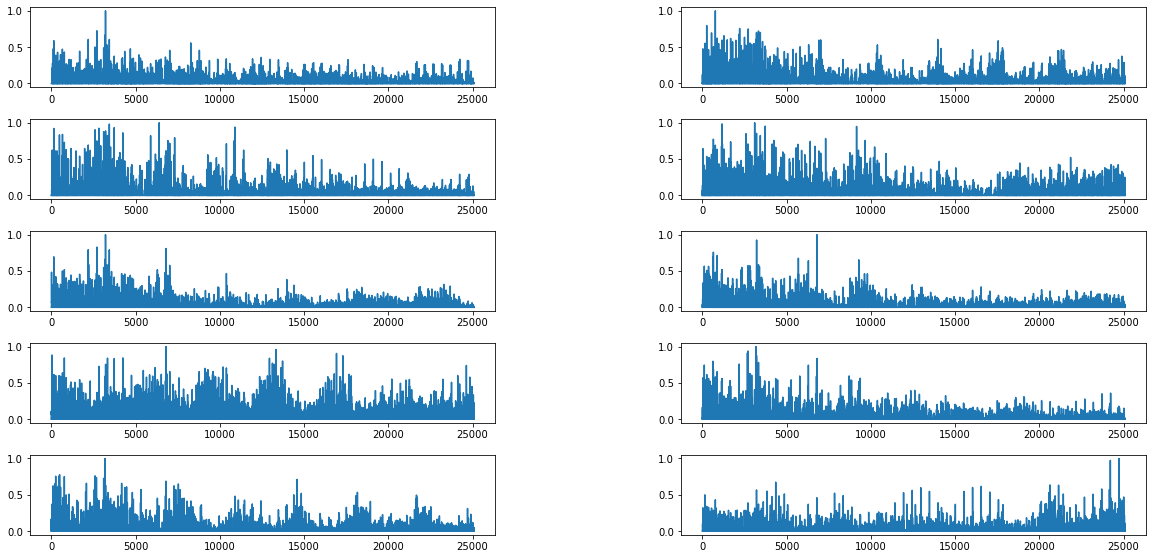

In [15]:
class_2_features = train_features[class_2_idx]
printFeaturesCluster(class_2_features)

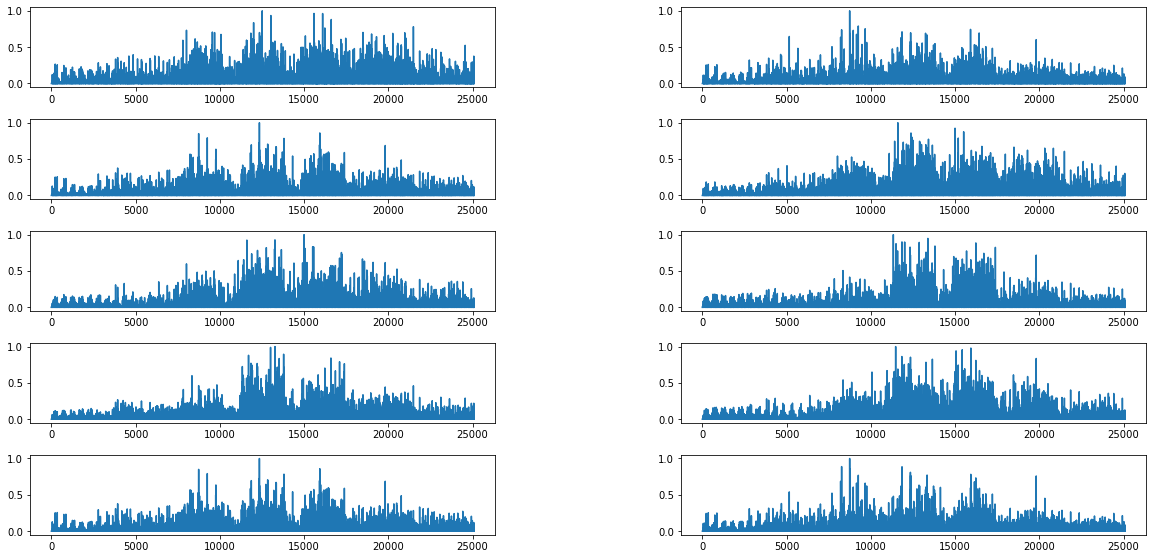

In [16]:
class_3_features = train_features[class_3_idx]
printFeaturesCluster(class_3_features)

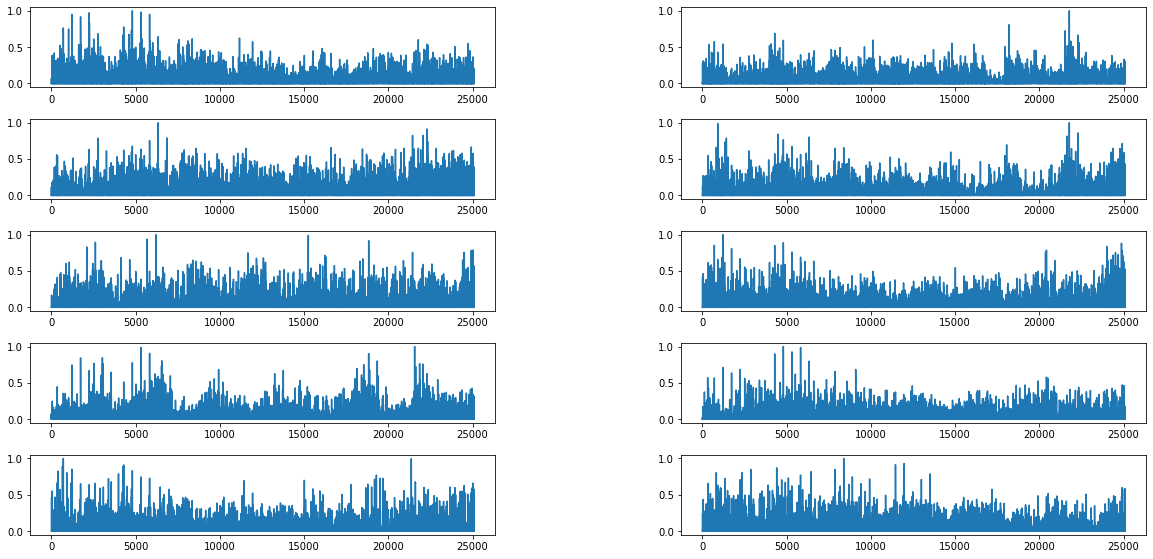

In [17]:
class_4_features = train_features[class_4_idx]
printFeaturesCluster(class_4_features)

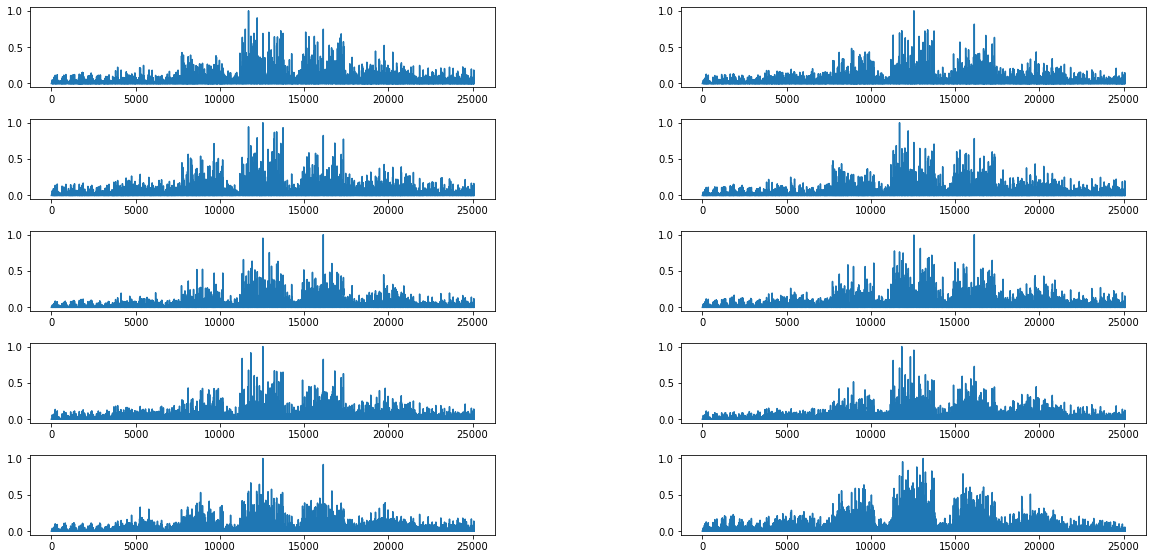

In [18]:
class_5_features = train_features[class_5_idx]
printFeaturesCluster(class_5_features)